In [12]:
# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import kneed

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

#SimpleImputer sklearn
#DBscan or other density techniques
import os

respectively 5,6 and 6 clusters

In [18]:
os.chdir('C:/Users/leonk/OneDrive/Documents/Tennis/TennisLab project')
data = pd.read_excel("Racquets_Master_DB.xlsx")
data = data.loc[data['circulation'] == "Yes"]



rec = data.loc[data['class']== "recreational"]
perf = data.loc[data['class'] == "performance"]
# for the moment we will stay with the performance raquets


c:\Users\leonk\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [19]:
p_specs = perf[['swingweight_unstrung', 'mass_unstrung', 'balance_unstrung', 'stiffness','beam1', 'beam2', 'beam3', 'headsize']].dropna()

In [20]:
scaler = StandardScaler()
p_specs_scaled = scaler.fit_transform(p_specs)
p_specs_scaled = pd.DataFrame(p_specs_scaled)
p_specs_scaled[1] = p_specs_scaled[1] * 2  # more importance for the variable mass?"""

## 1) K means clustering

c:\Users\leonk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\leonk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\leonk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\leonk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

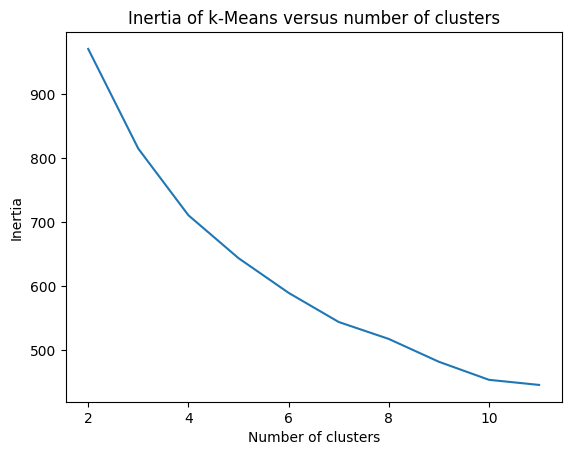

In [21]:
p_scores = [KMeans(n_clusters=i+2).fit(p_specs_scaled).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), p_scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters");

In [22]:
p_kmeans = KMeans(n_clusters=5, random_state=25)
p_kmeans.fit(p_specs_scaled)
p_kmeans_labels =pd.Series(p_kmeans.labels_)

pk_groups = perf.copy()
pk_groups['group'] = p_kmeans_labels.values 

c:\Users\leonk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
pk_group_values = pk_groups.group.value_counts().sort_index()
print('Performance Group Numbers', "\n", pk_group_values.to_string())

Performance Group Numbers 
 0    36
1    39
2    15
3    41
4    17


Text(0, 0.5, 'scaled value')

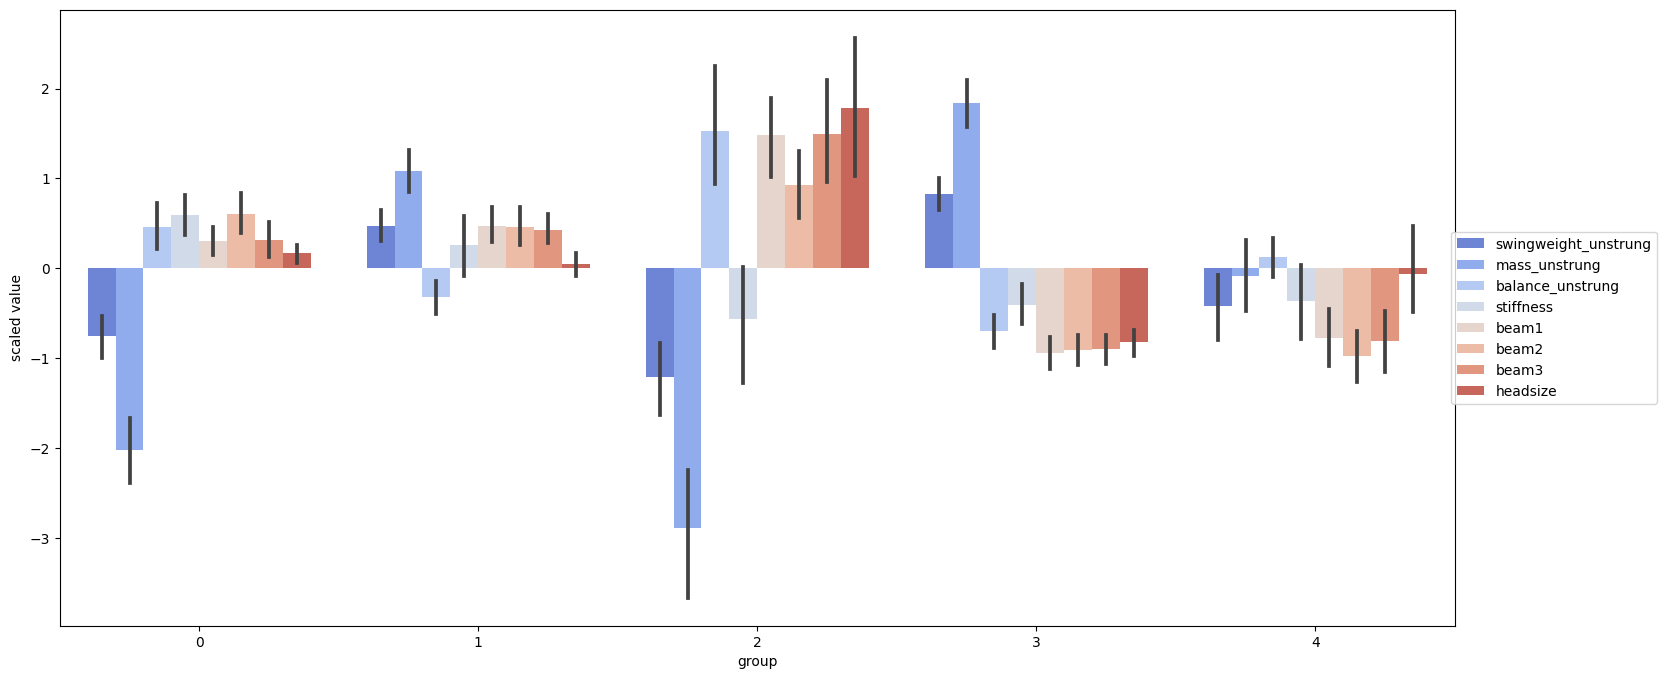

In [24]:
pspecs_scaled = pd.DataFrame((p_specs_scaled))
pspecs_scaled.columns = p_specs.columns
pspecs_scaled['kmeans'] = p_kmeans.labels_

# Plot data
p_tidy = pspecs_scaled.melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(x='kmeans', y='value', hue='variable', data=p_tidy, palette="coolwarm")
plt.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)
plt.xlabel('group')
plt.ylabel('scaled value')

In [25]:
pk_groups = pk_groups[['id','brand','model','group']]

In [26]:
pk_groups

,id,brand,model,group
1047,RR162,Tenx,Xcalibre+ (315g),3
1048,RR163,Tenx,Xcalibre+ (303g),4
1049,RR164,Tenx,Xcalibre+ (285g),4
1069,RR184,Babolat,Pure Drive,1
1091,RR204,Tenx,X Strike (300g),1
...,...,...,...,...
1331,RR421,Tecnifibre,TFight 280 ISO,0
1368,RR79,Babolat,Pure Aero Rafa,1
1371,RR80,Babolat,Pure Aero Team (2023),0
1372,RR80,Babolat,Pure Aero Rafa Team,0


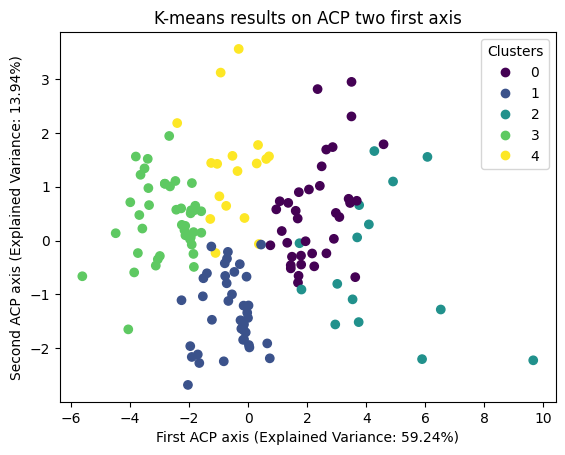

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Choisir le nombre de composantes principales souhaité (ici 2)
data_pca = pca.fit_transform(p_specs_scaled.drop('kmeans',axis = 1))  # Remplace 'your_data' par tes données
explained_variance = pca.explained_variance_ratio_



scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=p_specs_scaled['kmeans'])
plt.xlabel(f'First ACP axis (Explained Variance: {np.round(explained_variance[0] * 100, 2)}%)')
plt.ylabel(f'Second ACP axis (Explained Variance: {np.round(explained_variance[1] * 100, 2)}%)')
plt.title('K-means results on ACP two first axis')
plt.legend(*scatter.legend_elements(), title="Clusters")


plt.show()

## 2) Gaussian Mixture

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(p_specs_scaled)


df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
17,6,diag,706.098725
15,4,diag,754.021459
16,5,diag,769.322472
14,3,diag,795.194757
11,6,tied,814.499381


In [38]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.mixture import GaussianMixture

gaussian_model = GaussianMixture(n_components=6,covariance_type = 'diag')

# train the model
gaussian_model.fit(p_specs_scaled)

# assign each data point to a cluster
gaussian_result = gaussian_model.predict(p_specs_scaled)

# get all of the unique clusters
gaussian_clusters = unique(gaussian_result)

gaussian_result

array([1, 2, 2, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 2, 4, 4, 2, 1, 2, 4, 1, 0,
       2, 1, 2, 2, 1, 0, 3, 2, 5, 5, 4, 5, 3, 5, 0, 5, 5, 1, 1, 1, 0, 5,
       5, 5, 0, 2, 4, 4, 0, 4, 5, 3, 0, 0, 0, 4, 4, 1, 5, 2, 0, 1, 3, 3,
       3, 0, 0, 3, 5, 0, 0, 0, 0, 5, 5, 1, 1, 5, 3, 3, 4, 0, 0, 3, 5, 4,
       0, 0, 5, 4, 0, 4, 0, 4, 4, 5, 0, 2, 4, 5, 5, 5, 0, 4, 0, 0, 1, 5,
       0, 2, 4, 1, 3, 5, 3, 0, 1, 5, 5, 0, 0, 3, 5, 4, 1, 3, 2, 2, 1, 1,
       4, 0, 5, 5, 5, 0, 1, 1, 2, 2, 3, 5, 0, 5, 5, 4], dtype=int64)

In [39]:
gaussian_groups = pd.DataFrame(gaussian_result).value_counts().sort_index()
print('Performance Group Numbers', "\n", gaussian_groups.to_string())

Performance Group Numbers 
 0    39
1    20
2    17
3    15
4    21
5    36


In [53]:
pk_groups['gaussian']= gaussian_result

,id,brand,model,group,gaussian
1047,RR162,Tenx,Xcalibre+ (315g),3,1
1048,RR163,Tenx,Xcalibre+ (303g),4,2
1049,RR164,Tenx,Xcalibre+ (285g),4,2
1069,RR184,Babolat,Pure Drive,1,0
1091,RR204,Tenx,X Strike (300g),1,0
...,...,...,...,...,...
1331,RR421,Tecnifibre,TFight 280 ISO,0,5
1368,RR79,Babolat,Pure Aero Rafa,1,0
1371,RR80,Babolat,Pure Aero Team (2023),0,5
1372,RR80,Babolat,Pure Aero Rafa Team,0,5


In [57]:
p_specs_scaled = p_specs_scaled.drop('kmeans',axis = 1)
pspecs_scaled = pspecs_scaled.drop('kmeans',axis = 1)

In [58]:
pspecs_scaled = pd.DataFrame((p_specs_scaled))
pspecs_scaled.columns = p_specs.columns
pspecs_scaled['gaussian'] = gaussian_result


In [59]:
pspecs_scaled

,swingweight_unstrung,mass_unstrung,balance_unstrung,stiffness,beam1,beam2,beam3,headsize,gaussian
0,-0.084217,2.500124,-0.312101,-0.023209,-1.770081,-1.879945,-1.579287,-0.773131,1
1,-0.898866,1.103609,-0.812815,-0.023209,-1.770081,-1.879945,-1.579287,-0.773131,2
2,-2.283768,-0.991164,-0.312101,-0.023209,-1.770081,-1.879945,-1.579287,-0.773131,2
3,0.567502,0.754480,-0.312101,1.297927,0.206072,1.239246,0.427018,0.209044,0
4,1.056291,0.754480,-0.312101,-0.023209,0.403687,-0.164390,0.627648,0.209044,0
...,...,...,...,...,...,...,...,...,...
143,-0.735936,-1.573045,0.063435,1.033700,0.206072,-0.320349,0.427018,0.209044,5
144,0.893361,0.754480,-0.312101,1.297927,0.206072,1.239246,0.427018,0.209044,0
145,-0.817401,-0.991164,-0.312101,0.769472,0.206072,1.239246,0.427018,0.209044,5
146,-0.491541,-0.991164,-0.312101,1.297927,0.206072,1.239246,0.427018,0.209044,5


Text(0, 0.5, 'scaled value')

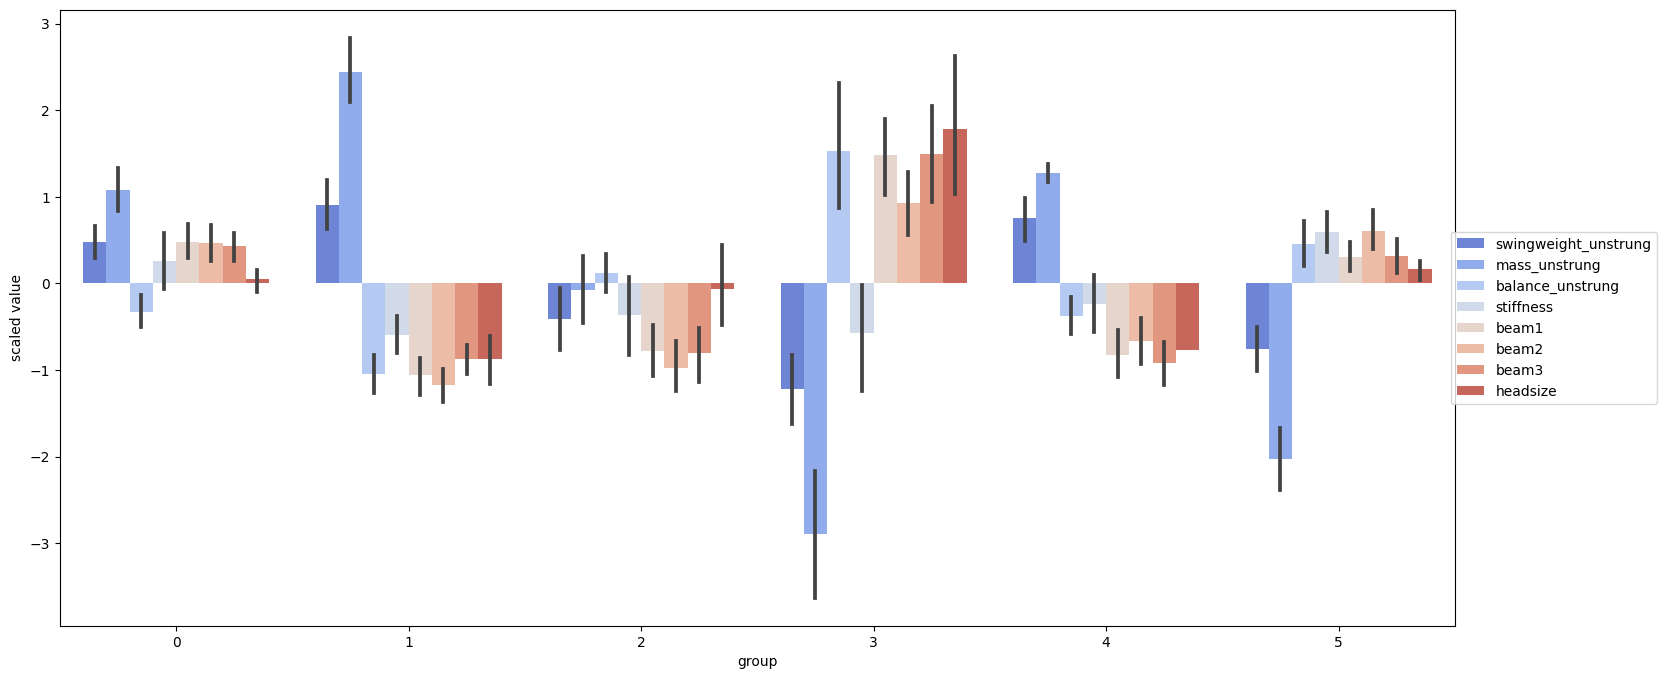

In [60]:
# Plot data
p_tidy = pspecs_scaled.melt(id_vars='gaussian')
fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(x='gaussian', y='value', hue='variable', data=p_tidy, palette="coolwarm")
plt.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)
plt.xlabel('group')
plt.ylabel('scaled value')

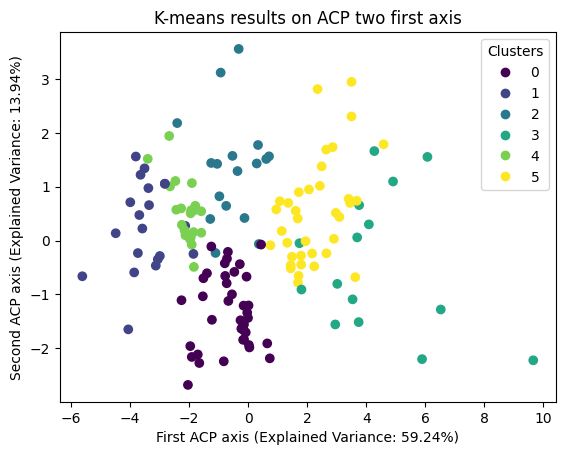

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Choisir le nombre de composantes principales souhaité (ici 2)
data_pca = pca.fit_transform(p_specs_scaled.drop('gaussian',axis = 1))  # Remplace 'your_data' par tes données
explained_variance = pca.explained_variance_ratio_



scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=p_specs_scaled['gaussian'])
plt.xlabel(f'First ACP axis (Explained Variance: {np.round(explained_variance[0] * 100, 2)}%)')
plt.ylabel(f'Second ACP axis (Explained Variance: {np.round(explained_variance[1] * 100, 2)}%)')
plt.title('K-means results on ACP two first axis')
plt.legend(*scatter.legend_elements(), title="Clusters")


plt.show()

## 3) Agglomerative clustering

In [29]:
p_specs_scaled

,swingweight_unstrung,mass_unstrung,balance_unstrung,stiffness,beam1,beam2,beam3,headsize,kmeans
0,-0.084217,2.500124,-0.312101,-0.023209,-1.770081,-1.879945,-1.579287,-0.773131,3
1,-0.898866,1.103609,-0.812815,-0.023209,-1.770081,-1.879945,-1.579287,-0.773131,4
2,-2.283768,-0.991164,-0.312101,-0.023209,-1.770081,-1.879945,-1.579287,-0.773131,4
3,0.567502,0.754480,-0.312101,1.297927,0.206072,1.239246,0.427018,0.209044,1
4,1.056291,0.754480,-0.312101,-0.023209,0.403687,-0.164390,0.627648,0.209044,1
...,...,...,...,...,...,...,...,...,...
143,-0.735936,-1.573045,0.063435,1.033700,0.206072,-0.320349,0.427018,0.209044,0
144,0.893361,0.754480,-0.312101,1.297927,0.206072,1.239246,0.427018,0.209044,1
145,-0.817401,-0.991164,-0.312101,0.769472,0.206072,1.239246,0.427018,0.209044,0
146,-0.491541,-0.991164,-0.312101,1.297927,0.206072,1.239246,0.427018,0.209044,0


In [33]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
clusters = hierarchy.linkage(p_specs_scaled, method="ward")

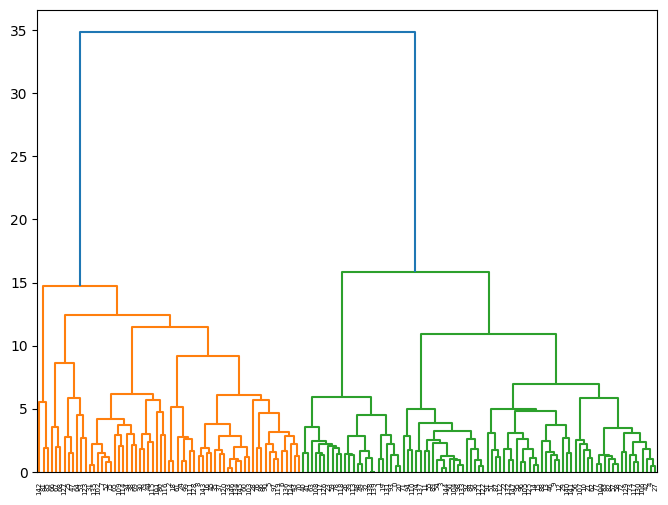

In [43]:
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

In [65]:
p_specs_scaled = p_specs_scaled.drop('gaussian',axis = 1)

In [50]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hierarchical_cluster.fit(p_specs_scaled)
hierarchical_cluster.labels_

c:\Users\leonk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([3, 3, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 3, 3, 2,
       2, 3, 1, 0, 3, 2, 1, 2, 0, 0, 3, 1, 0, 1, 2, 1, 0, 3, 3, 3, 2, 1,
       0, 1, 2, 0, 3, 3, 2, 2, 0, 0, 2, 2, 2, 2, 2, 3, 1, 1, 2, 3, 0, 0,
       0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 1, 2, 3, 0, 0, 0, 2, 2, 2, 0, 1, 2,
       2, 2, 1, 2, 2, 3, 2, 2, 2, 1, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 3, 0,
       2, 1, 2, 3, 0, 0, 0, 2, 3, 1, 1, 2, 2, 0, 1, 2, 3, 0, 1, 2, 2, 3,
       2, 2, 1, 0, 1, 2, 3, 3, 2, 2, 0, 1, 2, 1, 1, 2], dtype=int64)

In [53]:
pspecs_scaled = pd.DataFrame((p_specs_scaled))

pspecs_scaled.columns = p_specs.columns
p_specs_scaled['AGNES'] = hierarchical_cluster.labels_

pk_groups['AGNES'] = hierarchical_cluster.labels_

In [52]:
pspecs_scaled = pd.DataFrame((pspecs_scaled.drop('AGNES',axis = 1)))
p_specs_scaled = pd.DataFrame((p_specs_scaled.drop('AGNES',axis = 1)))


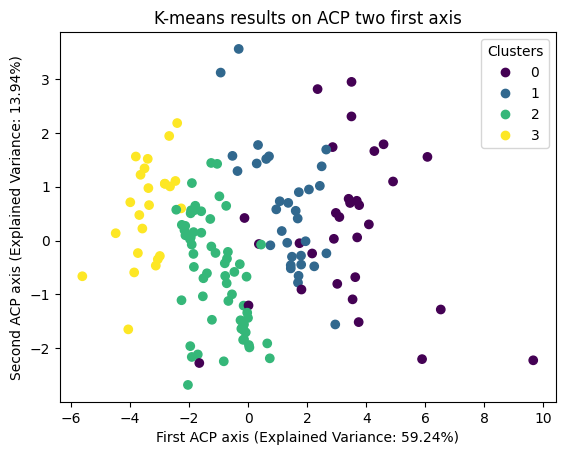

In [54]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Choisir le nombre de composantes principales souhaité (ici 2)
data_pca = pca.fit_transform(p_specs_scaled.drop('AGNES',axis = 1))  # Remplace 'your_data' par tes données
explained_variance = pca.explained_variance_ratio_


scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=p_specs_scaled['AGNES'])
plt.xlabel(f'First ACP axis (Explained Variance: {np.round(explained_variance[0] * 100, 2)}%)')
plt.ylabel(f'Second ACP axis (Explained Variance: {np.round(explained_variance[1] * 100, 2)}%)')
plt.title('K-means results on ACP two first axis')
plt.legend(*scatter.legend_elements(), title="Clusters")


plt.show()

Text(0, 0.5, 'scaled value')

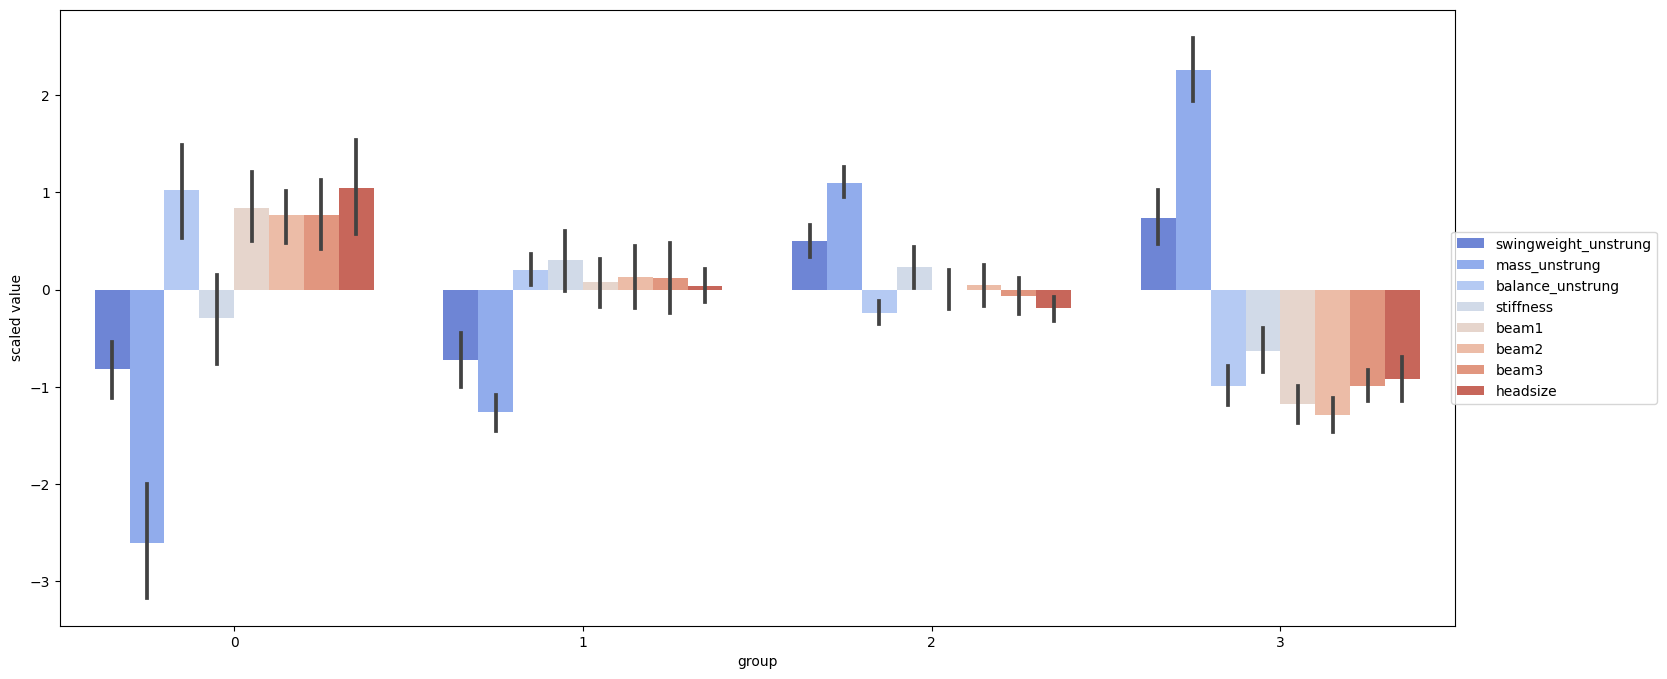

In [55]:
# Plot data
p_tidy = p_specs_scaled.melt(id_vars='AGNES')
fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(x='AGNES', y='value', hue='variable', data=p_tidy, palette="coolwarm")
plt.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)
plt.xlabel('group')
plt.ylabel('scaled value')

In [62]:
pk_groups.to_csv('raquetclusters.csv')